In [11]:
from __future__ import division, print_function
import csv, itertools, os, sys, math
from os.path import join
from scipy.io import savemat, loadmat
from scipy.ndimage import imread
from scipy.misc import imresize
from scipy.stats import entropy
import matplotlib.pyplot as plt
%matplotlib inline

from experimenter.nets import caffenet, write_net
from experimenter.nets.caffenet import default_train_transform_param
from experimenter.utilities import prototxt2protonet, num_lines

import random
import numpy as np
import caffe
caffe.set_mode_gpu()
caffe.set_device(0)

In [12]:
weights = 'caffe/ResNet-50-model.caffemodel'
model_def = 'prototxt/ResNet-50-imagenetval.prototxt'

In [92]:
# sys.exit(0)
np.random.seed(0)
datalist = 'data/imagenet_train.txt'
# select only validation images with labels from 0-20
with open(datalist) as f:
    lines = [ line for line in f.readlines() if int(line.split()[-1]) < 5 ]
np.random.shuffle(lines)
with open('data/imagenet_train_5.txt', 'w') as f:
    f.writelines(lines)

In [4]:
# non_block_layers = ['conv1']
# rest_layers = [ ['res2a', 'res2b', 'res2c'], ['res3a', 'res3b', 'res3c', 'res3d'], ['res4a', 'res4b', 'res4c', 'res4d', 'res4e', 'res4f'], ['res5a', 'res5b', 'res5c'] ]
# blocks = [ non_block_layers ]
# blocks.extend(rest_layers)
# all_layers = [ layer for sublist in blocks for layer in sublist ]
# rest_layers_flat = [layer for sublist in rest_layers for layer in sublist]
# NUM_CLASSES = 1000
# thresholds = np.hstack([ np.arange(0, 1, 0.1), np.arange(1, 3, 0.5),  range(3, 30, 1), range(30, 200, 60), [1000] ])
# num_bins = len(thresholds) - 1
# def run_batched_net(model_def, weights, limit=None, layers=all_layers):
#     netproto = prototxt2protonet(model_def)
#     data_param = netproto.layer[0].image_data_param
#     batch_size = data_param.batch_size
#     data_file = data_param.source
#     print(data_file)
#     net = caffe.Net(model_def, weights, caffe.TEST)

#     lines = num_lines(data_file)
#     lines = lines if limit is None else min(limit, lines)
#     layer_params = {}
#     histograms = {}
#     for layer in layers:
#         filters = net.blobs[layer].data[0].shape[0]
#         histograms[layer] = np.zeros( (filters, num_bins, NUM_CLASSES), dtype='uint32')

#     batches = lines // batch_size
#     remainder = lines % batch_size
#     for iter in range(batches):
#         net.forward()
#         labels = net.blobs['label'].data.astype(int)
#         for layer in layers:
#             filters, _, _ = histograms[layer].shape
#             for i in range(batch_size):
#                 data = net.blobs[layer].data[i].reshape( (filters, -1) )
#                 label = labels[i]
#                 for j in range(filters):
#                     bin_counts = np.histogram(data[j], bins=thresholds)[0]
#                     histograms[layer][j, :, label] += bin_counts
#         print('{} images'.format( (iter + 1) * batch_size ))

#     if remainder != 0:
#         net.forward()
#         labels = net.blobs['label'].data.astype(int)
#         for layer in layers:
#             filters, _, _ = histograms[layer].shape
#             for i in range(remainder):
#                 data = net.blobs[layer].data[i].reshape( (filters, -1) )
#                 label = labels[i]
#                 for j in range(filters):
#                     bin_counts = np.histogram(data[j], bins=thresholds)[0]
#                     histograms[layer][j, :, label] += bin_counts
#     return histograms

In [13]:
non_block_layers = ['conv1']
rest_layers = [ ['res2a', 'res2b', 'res2c'], ['res3a', 'res3b', 'res3c', 'res3d'], ['res4a', 'res4b', 'res4c', 'res4d', 'res4e', 'res4f'], ['res5a', 'res5b', 'res5c'] ]
blocks = [ non_block_layers ]
blocks.extend(rest_layers)
all_layers = [ layer for sublist in blocks for layer in sublist ]
rest_layers_flat = [layer for sublist in rest_layers for layer in sublist]
NUM_CLASSES = 20
def run_batched_net(model_def, weights, limit=None, layers=all_layers):
    netproto = prototxt2protonet(model_def)
    data_param = netproto.layer[0].image_data_param
    batch_size = data_param.batch_size
    data_file = data_param.source
    print(data_file)
    net = caffe.Net(model_def, weights, caffe.TEST)

    lines = num_lines(data_file)
    lines = lines if limit is None else min(limit, lines)
    layer_params = {}
    for layer in layers:
        filters = net.blobs[layer].data[0].shape[0]
        dim = net.blobs[layer].data[0].reshape( (filters, -1) ).shape[1]
        layer_params[layer] = np.empty( (filters, lines, dim), dtype='float32')

    batches = lines // batch_size
    remainder = lines % batch_size
    for iter in range(batches):
        net.forward()
        for layer in layers:
            filters, _, dim = layer_params[layer].shape
            data = net.blobs[layer].data.reshape( (batch_size, filters, -1) )
            data = data.transpose(1, 0, 2)
            layer_params[layer][:, batch_size * iter : batch_size * (iter + 1), :] = data
        print('{} images'.format( (iter + 1) * batch_size ))

    if remainder != 0:
        net.forward()
        for layer in layers:
            filters, _, dim = layer_params[layer].shape
            data = net.blobs[layer].data[:remainder].reshape( (remainder, filters, -1) )
            data = data.transpose(1, 0, 2)
            layer_params[layer][:, batch_size * (iter + 1) : , :] = data
    return layer_params

def get_labels(model_def, limit=None):
    netproto = prototxt2protonet(model_def)
    data_param = netproto.layer[0].image_data_param
    data_file = data_param.source
    with open(data_file) as f:
        lines = [ line.strip() for line in f.readlines()[:limit] ]
    return [int(line.split()[-1]) for line in lines]

In [14]:
def bin_data(data, labels, bins=100):
    filters, lines, dim = data.shape
    data = data.reshape( (filters, -1) )
    bin_widths = [ data.shape[1] // bins ] * bins
    for i in range(data.shape[1] % bins):
        bin_widths[i] += 1
    histograms = np.zeros( (filters, bins) )
    for i in range(filters):
        # decreasing order
        indices = data[i].argsort()[::-1]
        hist = np.zeros(NUM_CLASSES)
        cursor = 0
        current_bin = 0
        for index in indices:
            labels_index = index // dim
            hist[labels[labels_index]] += 1
            if cursor == bin_widths[current_bin]:
                histograms[i][current_bin] = entropy(hist)
                current_bin += 1
                cursor = 0
            cursor += 1
        histograms[i][current_bin] = entropy(hist)
    return histograms

In [15]:
prefix = 'histograms-5'

In [ ]:
sys.exit(0)
labels = get_labels(model_def, limit=5000)
for layer in all_layers:
    params = run_batched_net(model_def, weights, limit=5000, layers=[layer])
    histograms = bin_data(params[layer], labels)
    params[layer] = histograms
    # on python 2, too big for savemat
    np.savez('features/{}_{}.npz'.format(prefix,layer), **params)

In [7]:
entropies = {}
for layer in all_layers:
    path = 'features/{}_{}.npz'.format(prefix, layer)
    if os.path.isfile(path):
        entropies[layer] = np.load(path)[layer]

# for layer in all_layers:
#     histograms[layer] = histograms[layer].astype('uint64')

# for layer in all_layers:
#     data = histograms[layer]
#     filters = data.shape[0]
#     for i in range(filters):
#         accum = np.zeros(NUM_CLASSES, dtype='uint64')
#         for j in reversed(range(num_bins)):
#             accum += data[i, j, :]
#             data[i,j,:] = accum

In [8]:
# entropies = {}
# for layer in all_layers:
#     data = histograms[layer]
#     filters = data.shape[0]
#     entropies[layer] = np.zeros( (filters, num_bins), dtype='float64')
#     for i in range(filters):
#         # entropy will evaluate entropy for each *column* of a matrix
#         entropies[layer][i, :] = np.maximum(entropy(data[i, :, :].T), 0)

In [9]:
areaunderentropy = {}
for layer in all_layers:
    if layer not in entropies: continue
    filters, bins = entropies[layer].shape
    areaunderentropy[layer] = np.zeros(filters)
    for i in range(filters):
        areaunderentropy[layer][i] = np.trapz(entropies[layer][i], np.arange(bins))

In [85]:
# print(entropies['res3b'][:, 15].mean())
print(entropies['conv1'][:, 15].mean())

2.20701014299


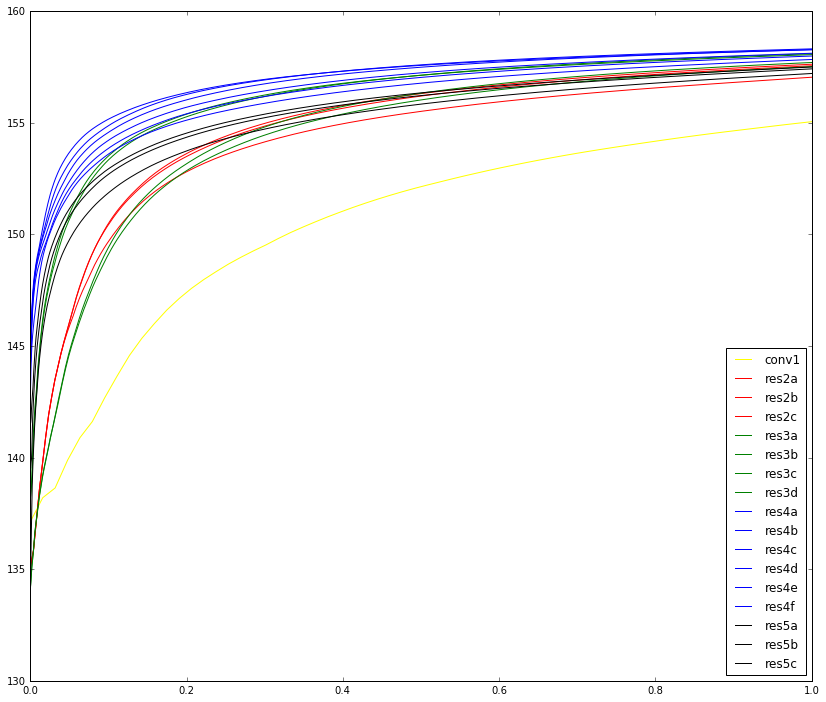

In [10]:
plt.figure(figsize=[14, 12])
colors = dict(conv1='yellow')
for layer in all_layers:
    if 'res2' in layer:
        colors[layer] = 'red'
    if 'res3' in layer:
        colors[layer] = 'green'
    if 'res4' in layer:
        colors[layer] = 'blue'
    if 'res5' in layer:
        colors[layer] = 'black'
for layer in all_layers:    
    if layer not in entropies: continue
    # calculate MCAuE (mean cumulative area under entropy)
    ys = np.cumsum(sorted(areaunderentropy[layer]))
    ys /= (np.arange(len(ys)) + 1)
    
    xs = np.linspace(0, 1, len(ys))
    plt.plot(xs, ys, label=layer, color=colors[layer])
plt.legend(loc='best')

In [8]:
def allow(key):
    filter_out = ['split', 'pool', 'data', 'label', 'prob', 'branch']
    for word in filter_out:
        if word in key:
            return False
    return True
keys = [ key for key in net.blobs.keys() if allow(key)]
print(keys)
print([ net.blobs[key].data[0].shape for key in keys ])
print()
print([ net.blobs[key].data[0].flatten().shape for key in keys ])
# net.blobs['conv1'].data[0].shape

['conv1', 'res2a', 'res2b', 'res2c', 'res3a', 'res3b', 'res3c', 'res3d', 'res4a', 'res4b', 'res4c', 'res4d', 'res4e', 'res4f', 'res5a', 'res5b', 'res5c', 'fc1000']
[(64, 112, 112), (256, 56, 56), (256, 56, 56), (256, 56, 56), (512, 28, 28), (512, 28, 28), (512, 28, 28), (512, 28, 28), (1024, 14, 14), (1024, 14, 14), (1024, 14, 14), (1024, 14, 14), (1024, 14, 14), (1024, 14, 14), (2048, 7, 7), (2048, 7, 7), (2048, 7, 7), (1000,)]

[(802816,), (802816,), (802816,), (802816,), (401408,), (401408,), (401408,), (401408,), (200704,), (200704,), (200704,), (200704,), (200704,), (200704,), (100352,), (100352,), (100352,), (1000,)]


In [17]:
net = caffe.Net(model_def, caffe.TEST)

In [43]:
net.blobs['conv1'].data.shape

(16, 64, 112, 112)